In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nbgwas
from nbgwas.nbgwas import Nbgwas

In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
nbgwas.__version__

'0.2.2'

# Gene Level Summary

In [5]:
%%time 

gene_level_summary_file = '../data/scz/gene_level_summary_stats_pmid_25056061.txt'
g = Nbgwas(gene_level_summary=gene_level_summary_file)

Loading network from NDEx...
CPU times: user 30.4 s, sys: 1.42 s, total: 31.8 s
Wall time: 43.1 s


In [7]:
%%time 

gene_level_summary_file = '../data/scz/gene_level_summary_stats_pmid_25056061.txt'
g = Nbgwas(gene_level_summary=gene_level_summary_file, 
           network=None, uuid=None)

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 59.5 ms


In [6]:
g.read_nx_pickle_file('../data/networks/pcnet.pkl')

In [7]:
g.gene_level_summary.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
0,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
1,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
2,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
3,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
4,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In [8]:
%%time 

g.diffuse(method='random_walk', alpha=0.5, name='a=0.5', replace=True)

CPU times: user 8.92 s, sys: 332 ms, total: 9.25 s
Wall time: 9.24 s


In [9]:
g.boosted_pvalues.head()

,a=0.5
Genes,
TCF4,0.539516
HIST1H4C,0.526994
HIST1H2BC,0.526892
HIST1H2BN,0.525755
HIST1H4J,0.525601


In [10]:
%%time 

g.diffuse(method='random_walk', alpha=0.2, name='a=0.2', replace=False)
g.diffuse(method='random_walk', alpha=0.8, name='a=0.8', replace=False)

CPU times: user 2.21 s, sys: 112 ms, total: 2.32 s
Wall time: 2.32 s


In [11]:
g.boosted_pvalues.head()

,a=0.5,a=0.2,a=0.8
Genes,,,
TCF4,0.539516,0.231018,0.823535
HIST1H4C,0.526994,0.224937,0.814388
HIST1H2BC,0.526892,0.224309,0.814440
HIST1H2BN,0.525755,0.222505,0.813839
HIST1H4J,0.525601,0.222313,0.813903


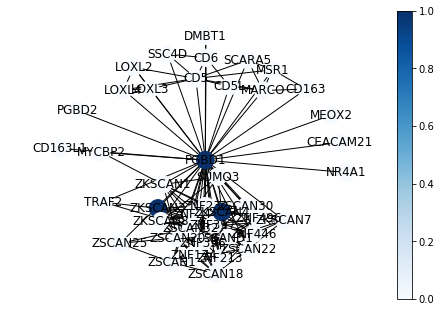

In [12]:
g.annotate_network(values="Heat", inplace=True)
g.view_subgraph('PGBD1', attributes="Heat")

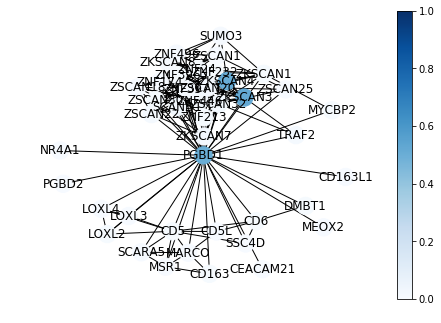

In [13]:
g.annotate_network(values="a=0.5", inplace=True)
g.view_subgraph('PGBD1', attributes="a=0.5")

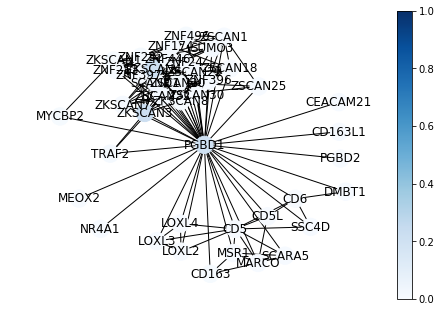

In [14]:
g.annotate_network(values="a=0.2", inplace=True)
g.view_subgraph('PGBD1', attributes="a=0.2")

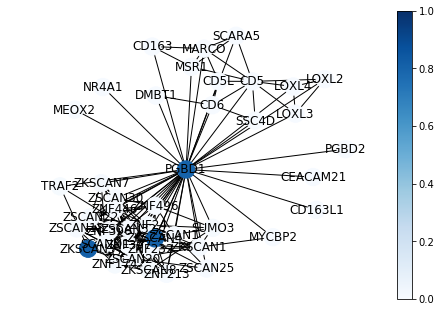

In [15]:
g.annotate_network(values="a=0.8", inplace=True)
g.view_subgraph('PGBD1', attributes="a=0.8")

# SNP Level Summary

In [16]:
del g

In [17]:
%%time 

snp_level_summary_file = '../data/scz/snp_level_summary_stats_pmid_25056061.txt'
protein_coding_file = '../data/glist-hg18_proteinCoding.txt'

g = Nbgwas(snp_level_summary=snp_level_summary_file, 
           protein_coding_table=protein_coding_file, 
           network=None, 
           uuid=None)

CPU times: user 1.88 s, sys: 140 ms, total: 2.02 s
Wall time: 2.05 s


In [18]:
%%time 

g.read_cx_file('../data/networks/GIANT.cx')

CPU times: user 41.4 s, sys: 1.75 s, total: 43.1 s
Wall time: 43.1 s


In [19]:
g.network

In [20]:
g.snp_level_summary.head()

,snpid,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
0,rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.16055
1,rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
2,rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,.
3,rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
4,rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.0925926


In [21]:
g.protein_coding_table.head()

,Chromosome,Start,End
A1BG,19,63551643,63565932
A1CF,10,52271589,52315441
A2M,12,9111570,9159825
A2ML1,12,8911704,8930864
A3GALT2,1,33544953,33559286


In [22]:
g.gene_level_summary

In [23]:
%%time

g.assign_pvalues(window_size=10000)

CPU times: user 1.91 s, sys: 96 ms, total: 2 s
Wall time: 2 s


In [24]:
g.gene_level_summary.head()

,Gene,Chromosome,Start,End,nSNPS,TopSNP P-Value,TopSNP Position
0,A1BG,19,63551643,63565932,12.0,0.117584,63556880.0
1,A1CF,10,52271589,52315441,21.0,0.247487,52290471.0
2,A2M,12,9111570,9159825,33.0,0.118248,9141868.0
3,A2ML1,12,8911704,8930864,31.0,0.173438,8920953.0
4,A3GALT2,1,33544953,33559286,17.0,0.100226,33551630.0


In [25]:
g.convert_to_heat()

In [26]:
g.heat.head()

,Heat
RNF14,0.0
UBE2Q1,0.0
UBE2Q2,0.0
RNF10,0.0
RNF11,0.0


In [27]:
g.convert_to_heat(method='neg_log')

In [28]:
g.heat.head()

,Heat
RNF14,3.184936
UBE2Q1,3.049072
UBE2Q2,1.235095
RNF10,2.250201
RNF11,1.908012
